In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
import string

# spacy
import spacy
!python -m spacy download en_core_web_sm

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dominic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 650.2 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.4/12.8 MB 2.5 MB/s eta 0:00:06
     --- ------------------------------------ 1.0/12.8 MB 5.0 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 9.1 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 12.3 MB/s eta 0:00:01
     ---------------- ----------------------- 5.2/12.8 MB 14.9 MB/s eta 0:00:01
     -------------------- ------------------- 6.5/12.8 MB 16.6 MB/s eta 0:00:01
     ------------------------ --------------- 8.0/12.8 MB 18.2 MB/s eta 0:00:01
     ----------------------------- ---------- 9.3/12.8 MB 19.2 MB/s eta 0:00:01
     -------------------------------- ------ 10.7/12

### Import the dataset and packages

The dataset is downloaded from Kaggle: [link](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv)

You can download it with the following link or download the train.csv file through Kaggle.

In [ ]:
%%bash
pip list | grep keras && pip list | grep nltk && pip list | grep spacy

keras                            2.15.0
tf_keras                         2.15.1
nltk                             3.8.1
spacy                            3.7.4
spacy-legacy                     3.0.12
spacy-loggers                    1.0.5


In [2]:
!wget -O data.csv https://www.dropbox.com/scl/fi/70e8lr0rsfx5crpmoxj8w/train_ensf.csv?rlkey=4s7p9dpm4fl9hnxiqtrmf2l7z&dl=0

'wget' is not recognized as an internal or external command,
operable program or batch file.
'dl' is not recognized as an internal or external command,
operable program or batch file.


**Task**:

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

**Columns**:

id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from (may be blank)

keyword - a particular keyword from the tweet (may be blank)

target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [3]:
# read the dataset
df = pd.read_csv("data.csv")

In [4]:
# how long is df?
len(df)

7613

In [5]:
# look at the head
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# find the unique values in target
df.target.unique()

array([1, 0], dtype=int64)

In [7]:
# create a column that has the name of the label instead of its digit call it label
decode_map = {0: "not_disasterous", 1: "disasterous"}
def decode_sentiment(label):
    return decode_map[int(label)]

df.loc[:, 'label'] = df.target.apply(lambda x: decode_sentiment(x))

In [8]:
# check the null values
print('null values of each field:\n', df.isnull().sum())

null values of each field:
 id             0
keyword       61
location    2533
text           0
target         0
label          0
dtype: int64


In [9]:
# fill keyword and location with 'no_key' and 'no_location'
df.keyword.fillna('no_keyword', inplace = True)
df.location.fillna('no_location', inplace = True)

Text(0.5, 1.0, 'Dataset labels distribuition')

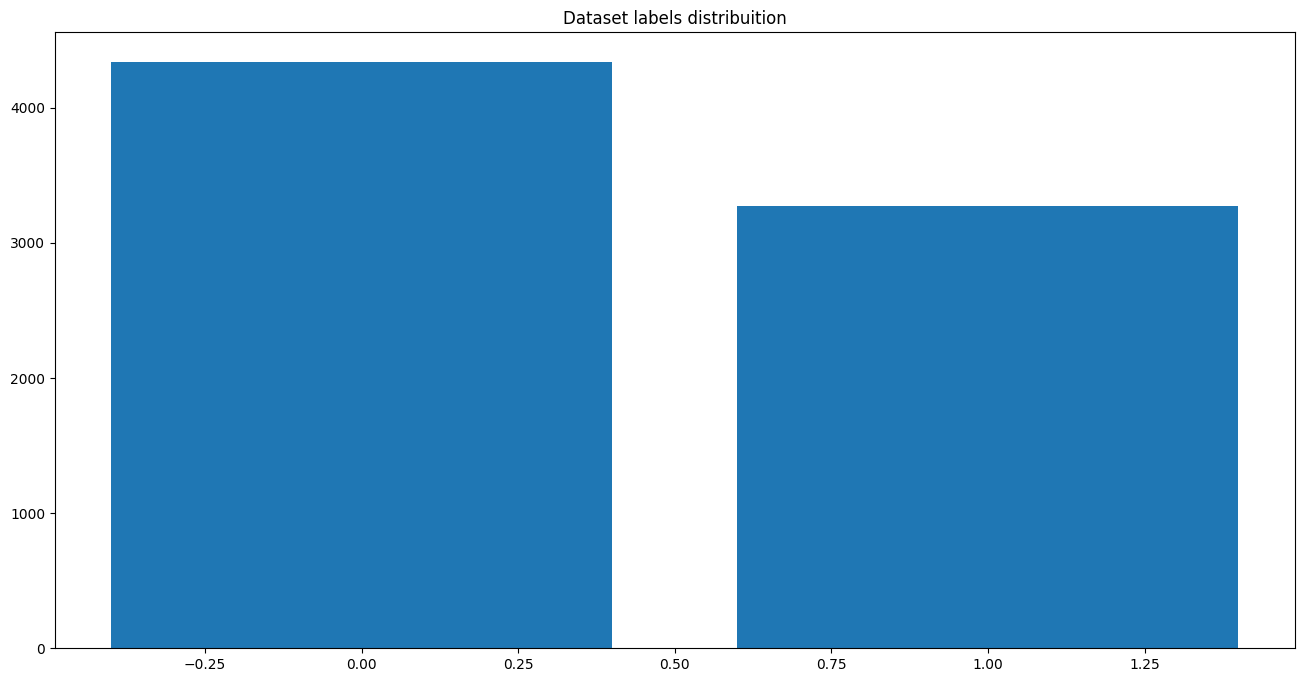

In [10]:
# visualize the number of negative and positive examples
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

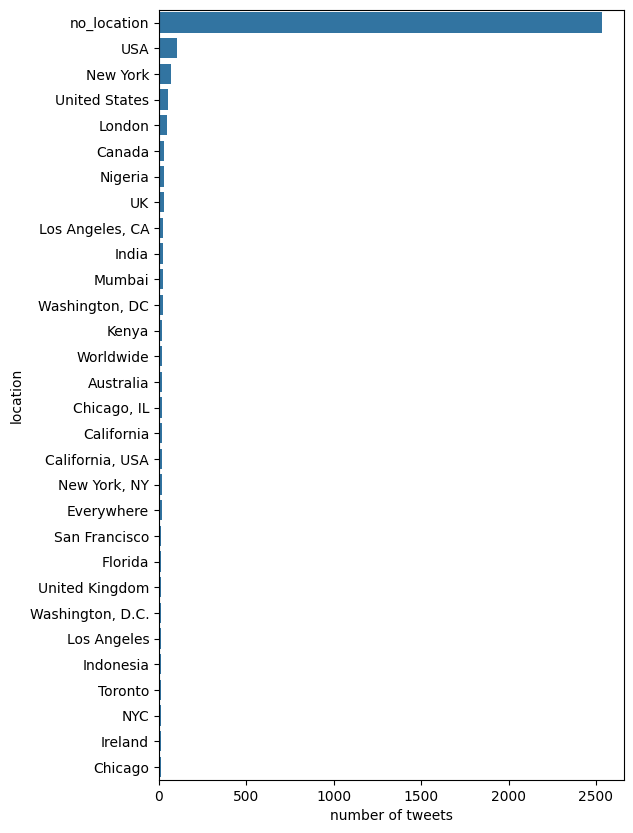

In [11]:
# what are the top 30 locations in the dataset

top_30 = df.groupby(['location']).count().text.sort_values(ascending = False)[:30]

# plot the top 30

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index);
plt.xlabel('number of tweets');

### Preprocessing

In [12]:
def preprocess(text:str) -> str:

    # lower case the words
    text = text.lower()

    # remove hyperlinks
    text = re.sub(r"\S*https?:\S*", "", text)

    # remove mentions and hashtags
    text = re.sub(r'[@#]\w*\_*' , '', text)

    # substitute patterns with their correct representation to remove
    rep_character_entity_refrences = {"&gt;": ">", "&lt;":"<",
                                      "&amp;": "&"}

    for k,v in rep_character_entity_refrences.items():
        text = re.sub(k, v, text)

    return text

df.loc[:, 'cleaned_text'] = df.loc[:, 'text'].apply(lambda x: preprocess(x))

In [13]:
df

,id,keyword,location,text,target,label,cleaned_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,disasterous,our deeds are the reason of this may allah fo...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,disasterous,forest fire near la ronge sask. canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,disasterous,all residents asked to 'shelter in place' are ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,disasterous,"13,000 people receive evacuation orders in ca..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,disasterous,just got sent this photo from ruby as smoke f...
...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,disasterous,two giant cranes holding a bridge collapse int...
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,disasterous,the out of control wild fires in california ...
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,disasterous,m1.94 [01:04 utc]?5km s of volcano hawaii.
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,disasterous,police investigating after an e-bike collided ...


NLTK (Natural Language Toolkit) and spaCy are two popular libraries used for NLP tasks in Python.

They both provide lists of stopwords for various languages, including English.

stopwords are common words that are often filtered out from text during preprocessing because they are considered to have little or no significance. Examples of NLTK English stopwords include "the," "is," "and," "but," etc.

In [14]:
# nltk stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

# spacy stopwords
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words.copy())

words_to_remove =  ['absolutely', "actually"]

all_stopwords = set(
    nltk_stopwords + spacy_stopwords + words_to_remove
    )

def remove_st(text:str) -> str:

    # Remove stopwords
    filtered_words = [word for word in text.split() if word not in all_stopwords]

    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)

    return filtered_text

# apply the remove st on cleaned_text
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_st(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
df

,id,keyword,location,text,target,label,cleaned_text,cleaned_text_no_st
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,disasterous,our deeds are the reason of this may allah fo...,deeds reason allah forgive
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,disasterous,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,disasterous,all residents asked to 'shelter in place' are ...,residents asked 'shelter place' notified offic...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,disasterous,"13,000 people receive evacuation orders in ca...","13,000 people receive evacuation orders califo..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,disasterous,just got sent this photo from ruby as smoke f...,got sent photo ruby smoke pours school
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,disasterous,two giant cranes holding a bridge collapse int...,giant cranes holding bridge collapse nearby homes
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,disasterous,the out of control wild fires in california ...,control wild fires california northern state. ...
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,disasterous,m1.94 [01:04 utc]?5km s of volcano hawaii.,m1.94 [01:04 utc]?5km volcano hawaii.
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,disasterous,police investigating after an e-bike collided ...,police investigating e-bike collided car littl...


In [16]:
def remove_punctuation_and_digits(text:str) -> str:

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\d', '', text)

    # removes all single letters surrounded with space except letters I and a
    text = re.sub(r'(?:^|\s)(?![ia])[a-z] +', ' ', text)

    return text

In [17]:
df.loc[:, 'cleaned_text'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_punctuation_and_digits(x))
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text_no_st'].apply(lambda x: remove_punctuation_and_digits(x))

In [18]:
df

,id,keyword,location,text,target,label,cleaned_text,cleaned_text_no_st
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,disasterous,our deeds are the reason of this may allah fo...,deeds reason allah forgive
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,disasterous,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,disasterous,all residents asked to shelter in place are be...,residents asked shelter place notified officer...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,disasterous,people receive evacuation orders in california,people receive evacuation orders california
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,disasterous,just got sent this photo from ruby as smoke f...,got sent photo ruby smoke pours school
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,disasterous,two giant cranes holding a bridge collapse int...,giant cranes holding bridge collapse nearby homes
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,disasterous,the out of control wild fires in california ...,control wild fires california northern state t...
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,disasterous,utckm of volcano hawaii,utckm volcano hawaii
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,disasterous,police investigating after an ebike collided w...,police investigating ebike collided car little...


A word cloud is a visual representation of text data, where the size of each word indicates its frequency or importance in the text.

Word clouds are often used to quickly and visually summarize the content of a large amount of text data.

They can help identify common themes, topics, or keywords within the text.

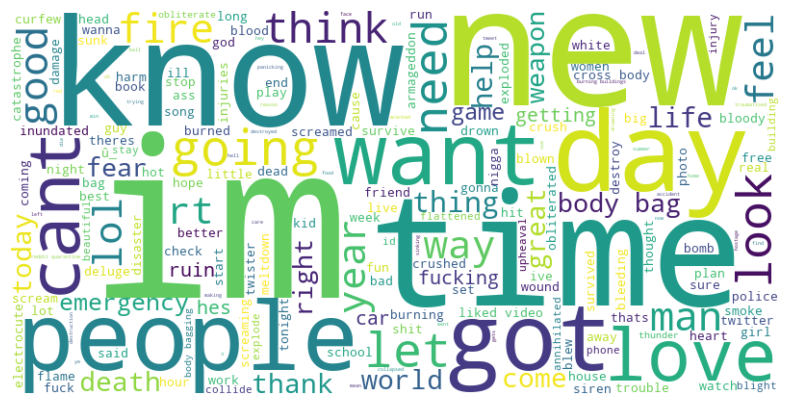

In [19]:
# build a word cloud for target == 0

# Combine all text from the specified column into a single string
text = ' '.join(df[df.target==0]['cleaned_text_no_st'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

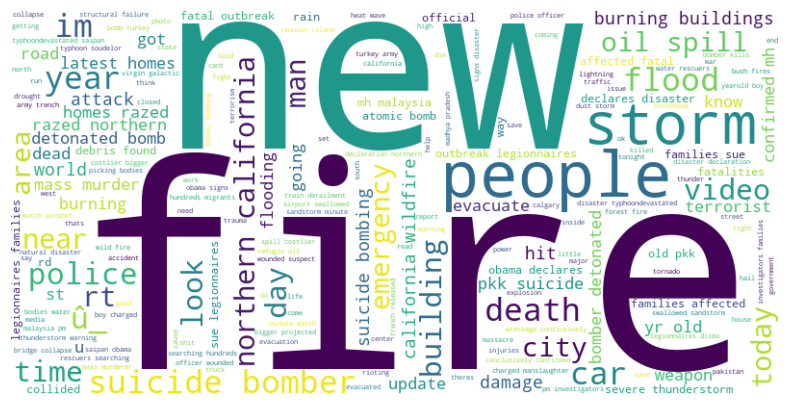

In [20]:
# build a word cloud for target == 1

# Combine all text from the specified column into a single string
text = ' '.join(df[df.target==1]['cleaned_text_no_st'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()


Tokenizing is the process of breaking down a text into smaller units, such as words or sentences, called tokens.

Tokenization is an essential step in NLP tasks because it allows the text to be processed at a more granular level.

Most frequent words:
fire: 177
suicide: 110
disaster: 110
california: 107
police: 106
people: 104
killed: 92
like: 92
pm: 89
fires: 85


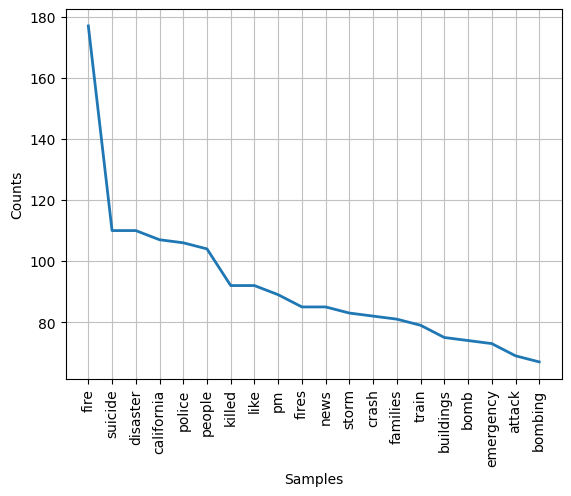

In [21]:
# view the most frequent words for target == 1

# Tokenize the text in the specified column
tokens = []
for text in df[df.target==1]['cleaned_text_no_st']:
    tokens.extend(word_tokenize(text))

# Calculate the frequency distribution of tokens
freq_dist = FreqDist(tokens)

# Display the most frequent words and their counts
most_common_words = freq_dist.most_common(10)
print("Most frequent words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Plot a bar chart of the frequency distribution
freq_dist.plot(20, cumulative=False)
plt.show()

### Prediction with RidgeClassifier, NaiveBayes, LinearSVM
Here we'll use counter vectorizer to specify one column for each word in the tweets and use it as a feature for prediction. If a tweet has a word, the column specife to that word will have the value of 1 (or more based on how many times that word has repeated in that tweet.)

As for the models, we chose these three because they can predict sparse data fast. You can go on and do gridsearch on them and find the best parameters for each.

In [22]:
# create a CountVectorizer function
counter_vectorizer = CountVectorizer()

# fit and transform the df
counter_vectorizer.fit(df.cleaned_text_no_st)
transformed_rows = counter_vectorizer.transform(df.cleaned_text_no_st).todense()

In [23]:
transformed_rows.shape

(7613, 13691)

In [24]:
# use the three algorithms and build cross validation to assess their performance
# make sure to create one pipeline with a feature selection algorithm inside it as well
import warnings
warnings.filterwarnings("ignore", message="Features.*", category=UserWarning)
warnings.filterwarnings("ignore", message="invalid.*", category=RuntimeWarning)

# Assuming you have your target variable 'y' and features 'transformed_rows'
# Example data
np.random.seed(42)
X = np.asarray(transformed_rows)
y = df.target
# y = df.target.values.reshape(-1, 1)

# Create a pipeline with feature selection and classifiers
ridge_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),  # Adjust k as needed
    ('classifier', RidgeClassifier())
])

naive_bayes_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', MultinomialNB())
])

linear_svm_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', SVC(kernel='linear'))
])

# Define the classifiers
classifiers = {
    'Ridge Classifier': ridge_pipeline,
    'Naive Bayes': naive_bayes_pipeline,
    'Linear SVM': linear_svm_pipeline
}

# Perform cross-validation and compare results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    y_pred = cross_val_predict(clf, X, y, cv=cv)

    # Print confusion matrix and metrics
    print(f'\nResults for {name}:')
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y, y_pred))

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')



Results for Ridge Classifier:
Confusion Matrix:
[[3989  353]
 [1738 1533]]
Accuracy: 0.73
Precision: 0.81
Recall: 0.47
F1 Score: 0.59

Results for Naive Bayes:
Confusion Matrix:
[[4131  211]
 [2024 1247]]
Accuracy: 0.71
Precision: 0.86
Recall: 0.38
F1 Score: 0.53

Results for Linear SVM:
Confusion Matrix:
[[3948  394]
 [1702 1569]]
Accuracy: 0.72
Precision: 0.80
Recall: 0.48
F1 Score: 0.60


***Your Turn***


The dataset is downloaded from Kaggle: [link](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets)

In [25]:
# Optional, import data with kaggle API
import pathlib 
import zipfile
_DATA_PATH = pathlib.Path('../data/lab-7')

def get_kaggle_dataset(comp_name: str, path: pathlib.Path) -> None:
        
    try: 
        import kaggle
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(comp_name, path=path)
    except ModuleNotFoundError as e:
        print("Kaggle not installed, use 'pip install kaggle' or " 
            "'conda install -c conda-forge kaggle' and restart Jupyter kernel. "
            "Otherwise, download data and place in folder above manually"
        )
        print(e.message())
    except Exception as e:
        raise e

def unzip_file(path: pathlib.Path, fname:str) -> None:
    with zipfile.ZipFile(path / fname, "r") as handle:
        handle.extractall(path)

get_kaggle_dataset("emineyetm/fake-news-detection-datasets", _DATA_PATH)
unzip_file(_DATA_PATH, "fake-news-detection-datasets.zip")
print(f"Data extracted to: {_DATA_PATH.resolve()}")

Data extracted to: C:\Users\dominic\Desktop\Schoolwork\2024_Q1_Winter\Labs\ENSF-444-Labs\data\lab-7


In [26]:
# df_true = pd.read_csv('/content/True.csv')
# df_fake = pd.read_csv('/content/Fake.csv')

df_true = pd.read_csv(_DATA_PATH / "News _dataset" / 'True.csv')
df_fake = pd.read_csv(_DATA_PATH / "News _dataset" / 'Fake.csv')

df_fake["target"] = 0
df_true["target"] = 1

df = pd.concat([df_fake,df_true], axis = 0).drop(["title", "subject","date"], axis = 1).sample(frac = 1)

df.isnull().sum()

text      0
target    0
dtype: int64

In [27]:
df = df.reset_index(drop=True)
df.head()

,text,target
0,LONDON (Reuters) - Britain s government said o...,1
1,WASHINGTON (Reuters) - Director of National In...,1
2,"Former Navy SEAL and GOP Rep. Scott Taylor, R-...",0
3,WASHINGTON (Reuters) - The White House on Thur...,1
4,BERN (Reuters) - European and African minister...,1


In [28]:
def preprocess(text:str) -> str:

    # lower case the words
    text = text.lower()

    # remove hyperlinks
    text = re.sub(r"\S*https?:\S*", "", text)

    # remove mentions and hashtags
    text = re.sub(r'[@#]\w*\_*' , '', text)

    # substitute patterns with their correct representation to remove
    rep_character_entity_refrences = {"&gt;": ">", "&lt;":"<",
                                      "&amp;": "&"}
    return text

In [29]:
# nltk stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

# spacy stopwords
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words.copy())


words_to_remove =  ['absolutely', "actually"]

all_stopwords = set(
    nltk_stopwords + spacy_stopwords + words_to_remove
    )

def remove_st(text:str) -> str:

    # Remove stopwords
    filtered_words = [word for word in text.split() if word not in all_stopwords]
    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def remove_punctuation_and_digits(text:str) -> str:

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits
    text = re.sub(r'\d', '', text)
    # removes all single letters surrounded with space except letters I and a
    text = re.sub(r'(?:^|\s)(?![ia])[a-z] +', ' ', text)
    
    return text

In [31]:
# apply preprocessing function
df.loc[:, 'cleaned_text'] = df.loc[:, 'text'].apply(lambda x: preprocess(x))

# apply the remove st on cleaned_text
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_st(x))

# remove punctuation and digits
df.loc[:, 'cleaned_text'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_punctuation_and_digits(x))
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text_no_st'].apply(lambda x: remove_punctuation_and_digits(x))

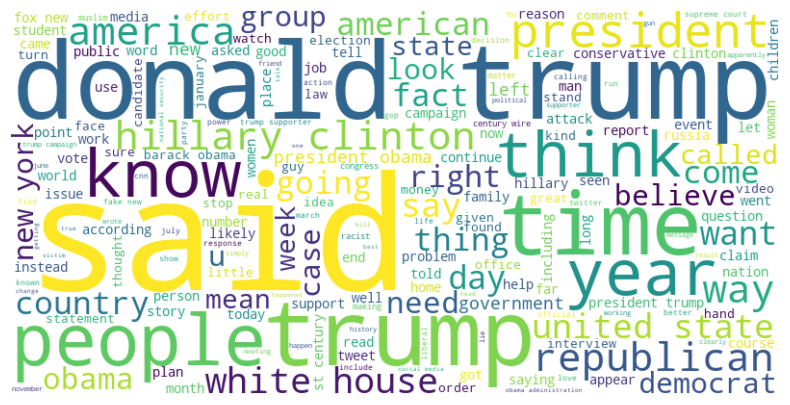

In [32]:
# build a word cloud for target == 0

# Combine all text from the specified column into a single string
text = ' '.join(df[df.target==0]['cleaned_text_no_st'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

Most frequent words:
said: 99039
trump: 42595
us: 39395
reuters: 28404
president: 25548
state: 18757
government: 17980
states: 17638
new: 16786
house: 16407


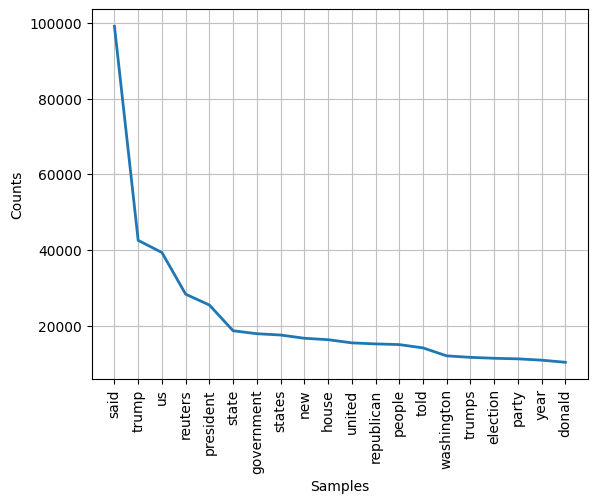

In [35]:
# view the most frequent words for target == 1

# Tokenize the text in the specified column
tokens = []
for text in df[df.target==1]['cleaned_text_no_st']:
    tokens.extend(word_tokenize(text))

# Calculate the frequency distribution of tokens
freq_dist = FreqDist(tokens)

# Display the most frequent words and their counts
most_common_words = freq_dist.most_common(10)
print("Most frequent words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Plot a bar chart of the frequency distribution
freq_dist.plot(20, cumulative=False)
plt.show()

In [55]:
# create a CountVectorizer function
cv = CountVectorizer(max_features=10000)

# fit and transform the df
cv.fit(df.cleaned_text_no_st)
transformed_rows = cv.transform(df.cleaned_text_no_st).todense()

transformed_rows.shape

(44898, 10000)

In [57]:
# use the three algorithms and build cross validation to assess their performance
# make sure to create one pipeline with a feature selection algorithm inside it as well

# Assuming you have your target variable 'y' and features 'transformed_rows'
# Example data
np.random.seed(42)
X = np.asarray(transformed_rows)
# y = df.target.values.reshape(-1, 1)
y = df.target

# Create a pipeline with feature selection and classifiers
ridge_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),  # Adjust k as needed
    ('classifier', RidgeClassifier())
])

naive_bayes_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', MultinomialNB())
])

linear_svm_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', SVC(kernel='linear'))
])

# Define the classifiers
classifiers = {
    'Ridge Classifier': ridge_pipeline,
    'Naive Bayes': naive_bayes_pipeline,
    'Linear SVM': linear_svm_pipeline
}

# Perform cross-validation and compare results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    y_pred = cross_val_predict(clf, X, y, cv=cv)

    # Print confusion matrix and metrics
    print(f'\nResults for {name}:')
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y, y_pred))

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')



Results for Ridge Classifier:
Confusion Matrix:
[[23233   248]
 [  195 21222]]
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 Score: 0.99

Results for Naive Bayes:
Confusion Matrix:
[[21804  1677]
 [  186 21231]]
Accuracy: 0.96
Precision: 0.93
Recall: 0.99
F1 Score: 0.96

Results for Linear SVM:
Confusion Matrix:
[[23339   142]
 [   46 21371]]
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1 Score: 1.00
